# A toy solar system playbook

Mal Minhas

## History
* **20.12.21 v0.1**: First version based on code [here](https://thepythoncodingbook.com/2021/12/11/simulating-3d-solar-system-python-matplotlib/)
* **21.12.21 v0.2**: Created `JupyterMatplotlibCanvas` implementation and got it working
* **22.12.21 v0.3**: Refined `JupyterMatplotlibCanvas` implementation and added a default canvas which uses `%matplotlib inline`

[This blog post](https://thepythoncodingbook.com/2021/12/11/simulating-3d-solar-system-python-matplotlib/) describes a really neat little implementation of a toy solar system from first principles.  The system described works in standalone mode using `matplotlib`.  This Jupyter notebook helps to explain the context and interleave it with full working code that runs as a crude animation using a Juptyer `matplotlib` canvas class.  This opens the path for implementations targetting other environments.  Note that `%matplotlib widget` (ie. `ipympl`) support doesn't seem to be working properly in the local setup so this notebook is leveraging `JupyterMatplotlibCanvas` and not the interactive variant.

<div id='solar-system-contents'/>

## Contents

* [**Canvas implementation**](#solar-system-canvas) - Canvas implementation to render solar system within Jupyter environment
* [**`Vector` class**](#solar-system-vector) - Implementation of a `Vector` class
* [**`SolarSystem` classes**](#solar-system-bodies) - Implementation of `SolarSystem` and `SolarSystemBody` classes
* [**`Sun`and `Planet` classes**](#solar-system-planets) - Implementation of `Sun` and `Planet` classes

<div id='solar-system-canvas'/>

## 1. Canvas implementation
[**back to Contents**](#solar-system-contents)

Let's start with an abstract base class called `AbstractCanvas` that all canvas implementations will inherit from:

In [1]:
from abc import ABC, abstractmethod

class AbstractCanvas(ABC):
    ''' Abstract base class for all canvas instantiations '''
    @abstractmethod
    def initialise_canvas(self, **kwargs):
        raise NotImplemented

    @abstractmethod
    def clear_all(self, **kwargs):
        raise NotImplemented

    @abstractmethod
    def update_body(self, **kwargs):
        raise NotImplemented
        
    @abstractmethod
    def draw_all(self, **kwargs):
        raise NotImplemented

We can now use it to build a canvas suitable for displaying moving objects in `jupyter-matplotlib`.  The implementation will be called `JupyterMatplotlibInteractiveCanvas` and it will have the following dependencies:
* [`%matplotlib widget`](https://github.com/matplotlib/ipympl) magic enables the `widget` backend which requires `jupyter-matplotlib` (aka `ipympl`) making `matplotlib` plots interactive.  This in turn allows us to run a basic animation of the solar system.
* `plt.subplots` house a single 3d projection subplot for displaying the solar system 
* [`plt.tight_layout`](https://matplotlib.org/3.1.1/tutorials/intermediate/tight_layout_guide.html) for cleanly laying out a plot in the `matplotlib` figure.
* `[plt.rcParams['savefig.facecolor'] = "0.8"` for setting the fig background to grey
* `size` sets the size of the 3d projection cube.
* `IPython.display.clear_output(wait=False)` clears the output of the current cell receiving output.

In [2]:
%matplotlib widget

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

plt.rcParams['savefig.facecolor'] = "0.8"

class JupyterMatplotlibInteractiveCanvas(AbstractCanvas):
    ''' jupyter-matplotlib canvas instantiation '''
    def __init__(self, size=400, delay=0.001, azimuth=45, elevation=45):
        self.delay = delay
        self.ax = None
        self.size = size
        self.azimuth = azimuth
        self.elevation = elevation
        self.initialise_canvas()
        #print(f"init canvas with {mpl.get_backend()} backend")

    def __del__(self):
        try:
            self.fig.canvas.close()
        except:
            pass
        
    def initialise_canvas(self, **kwargs):
        ''' initialise canvas to a single matplotlib 3d plot '''
        self.fig, self.ax = plt.subplots(
            1,
            1,
            subplot_kw={"projection": "3d"},
            figsize=(self.size / 50, self.size / 50),
        )
        # These next four don't seem to do anything
        self.fig.canvas.toolbar_visible = True
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False
        self.fig.canvas.resizable = True
        # tight_layout reduces the margins at the edge of the figure.
        self.fig.tight_layout()
        # we can change perspective to have x-axis perpendicular to screen by setting (azimuth,elevation) to (0,0)
        self.ax.view_init(self.azimuth, self.elevation)
        
    def clear_all(self, **kwargs):
        pass

    def update_body(self, body, position, colour, markersize):
        ''' draw individual body to canvas '''
        self.ax.plot(
            position[0],position[1],position[2],
            marker="o",
            markersize=markersize,
            color=colour
        )

    def draw_all(self, **kwargs):
        ''' set the limits for the three axes using the solar system’s size and update the plot through the pause() function. 
        Also clear the axes, ready for the next plot '''
        self.ax.set_xlim((-self.size / 2, self.size / 2))
        self.ax.set_ylim((-self.size / 2, self.size / 2))
        self.ax.set_zlim((-self.size / 2, self.size / 2))
        # The active figure will be updated and displayed before the pause + the GUI event loop (if any) will run during the pause.
        plt.pause(self.delay)
        self.ax.clear()
        # Note that without this line in Jupyter you get multiple plots on calling update/draw here
        clear_output(wait=True)

Let's instantiate a `JupyterMatplotlibCanvas`:

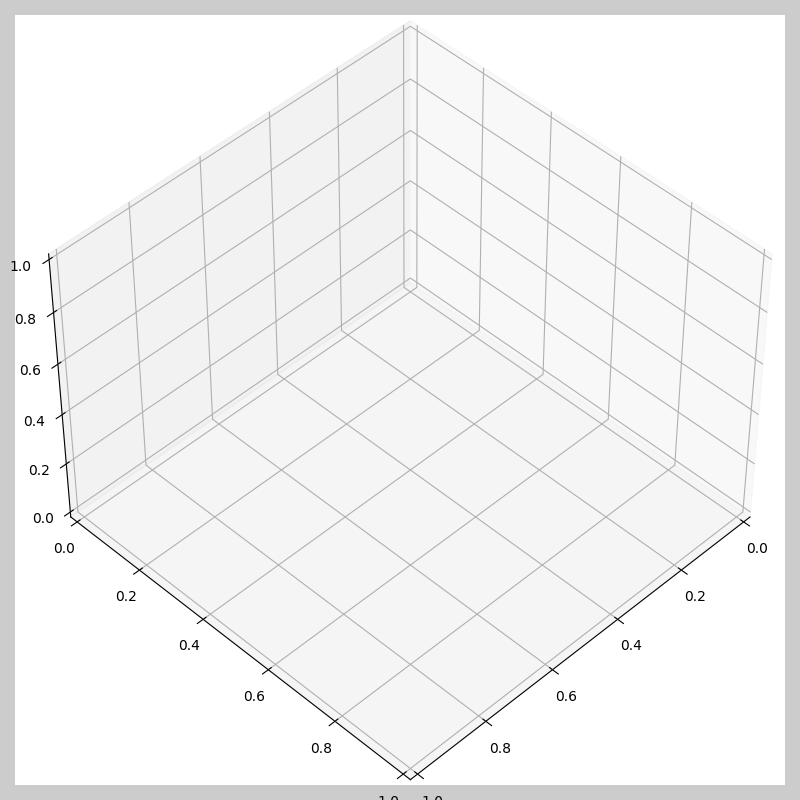

In [3]:
canvas = JupyterMatplotlibInteractiveCanvas(size=400, delay=0.1, azimuth=45,elevation=45)

We will also create a `JupyterMatplotlibCanvas` that using `%matplotlib inline` to create a non-interactive 3d grid: 

In [4]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

class JupyterMatplotlibCanvas(AbstractCanvas):
    ''' jupyter-matplotlib canvas instantiation '''
    def __init__(self, size=400, delay=0.001, azimuth=45, elevation=45):
        self.delay = delay
        self.ax = None
        self.size = size
        self.azimuth = azimuth
        self.elevation = elevation
        self.hdisplay = None
        self.plot_list = {}
        self.initialise_canvas()

    def __del__(self):
        try:
            plt.close(self.fig)
        except:
            pass
        
    def initialise_canvas(self, **kwargs):
        ''' initialise canvas to a single matplotlib 3d plot '''
        self.fig, self.ax = plt.subplots(
            1,
            1,
            subplot_kw={"projection": "3d"},
            figsize=(self.size / 50, self.size / 50),
        )
        # These next four don't seem to do anything
        self.fig.canvas.toolbar_visible = True
        self.fig.canvas.header_visible = True
        self.fig.canvas.footer_visible = True
        self.fig.canvas.resizable = True
        # tight_layout reduces the margins at the edge of the figure.
        self.fig.tight_layout()        
        # we can change perspective to have x-axis perpendicular to screen by setting (azimuth,elevation) to (0,0)
        self.ax.view_init(self.azimuth, self.elevation)
        self.hdisplay = display(display_id=True)
        self.body_list = []
        
    def clear_all(self, **kwargs):
        ''' update the solar system’s size and clear the axes, ready for the next plot '''
        self.ax.clear()
        self.body_list = []
        clear_output(wait=True)

    def update_body(self, body, position, colour, markersize):
        ''' draw body then add it to a body list so we can clear it '''
        self.ax.plot(
            position[0],position[1],position[2],
            marker="o",
            markersize=markersize,
            color=colour
        )
        d = {'x':position[0],'y':position[1],'z':position[2],'marker':'o','markersize':markersize,'color':colour}
        self.body_list.append(d)

    def draw_all(self, **kwargs):
        self.ax.set_xlim((-self.size / 2, self.size / 2))
        self.ax.set_ylim((-self.size / 2, self.size / 2))
        self.ax.set_zlim((-self.size / 2, self.size / 2))
        for d in self.body_list:
            x = d.get('x')
            y = d.get('y')
            z = d.get('z')
            mk = d.get('marker')
            mks = d.get('markersize')
            c = d.get('color')
            self.ax.plot(
                x,y,z,
                marker=mk,
                markersize=mks,
                color=c
            )
        self.hdisplay.update(self.fig)

Let's also instantiate this one:

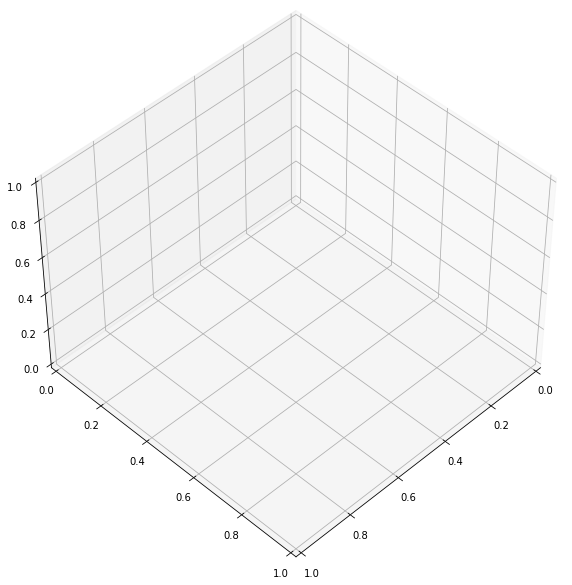

In [5]:
canvas = JupyterMatplotlibCanvas(size=400, delay=0.1, azimuth=45,elevation=45)

For completeness we could look at building 3 rotating 3d grid based on `%matploblib widget` recipe [outlined here](https://www.geeksforgeeks.org/make-3d-interactive-matplotlib-plot-in-jupyter-notebook/).  However, interactive so we'll stick with `JupyterMatplotlibCanvas` for now.  We'll return to this canvas later.  First in the next section we will build a `Vector` class from the ground up.

<div id='solar-system-vector'/>

## 2. `Vector` class
[**back to Contents**](#solar-system-contents)

### 2.1 Implementation

The following is a fully fleshed out implementation of a vector class.  The class is indexable through `__getitem__` and includes support for both scalar multiplication and dot product in `__mul__` depending on input using [function overloading](https://mypy.readthedocs.io/en/stable/more_types.html?highlight=overload#function-overloading).  Note we also have support for deriving the `magnitude` of the vector as well as its `normalized` version.  Type hinting is used throughout using [forward declaration](https://legacy.python.org/dev/peps/pep-0484/#forward-references) of `Vector`.

In [6]:
import math
from typing import Union, overload

class Vector(object):

    def __init__(self, x:float=0, y:float=0, z:float=0):
        self.x = x
        self.y = y
        self.z = z
        
    def __repr__(self) -> str:
        '''  returns an output intended for a programmer showing the class name. The output from __repr__() can be used to recreate the object.'''
        return f"Vector({self.x},{self.y},{self.z})"
    
    def __str__(self) -> str:
        ''' returns a non-programmer’s version of the string representation of the object.'''
        return f"{self.x}i,{self.y}j,{self.z}k"
    
    def __getitem__(self, item:int) -> float:
        ''' make the Vector class indexable with [] '''
        if item == 0:
            return self.x
        elif item == 1:
            return self.y
        elif item == 2:
            return self.z
        else:
            raise IndexError("There are only three elements in the vector")

    def __setitem__(self, item:int, v:float):
        ''' make the Vector class settable with [] '''
        if item == 0:
            self.x = v
        elif item == 1:
            self.y = v
        elif item == 2:
            self.z = v
        else:
            raise IndexError("There are only three elements in the vector")
            
    def __add__(self, v:'Vector') -> 'Vector':
        ''' vector addition '''
        return Vector(
            self.x + v.x,
            self.y + v.y,
            self.z + v.z
        )
    
    def __sub__(self, v:'Vector') -> int:
        ''' vector subtraction '''
        return Vector(
            self.x - v.x,
            self.y - v.y,
            self.z - v.z
        )

    @overload
    def __mul__(self, v:'Vector') -> float: ...
    
    @overload
    def __mul__(self, v:int) -> 'Vector': ...

    @overload
    def __mul__(self, v:float) -> 'Vector': ...
            
    def __mul__(self, v:Union['Vector',int,float]) -> Union[float,'Vector','Vector']:
        ''' returns the  vector '''
        if isinstance(v, Vector):
            # return the dot product of two vectors
            return self.x * v.x + self.y * v.y + self.z * v.z
        elif isinstance(v, (int,float)):
            ''' returns the  vector '''
            return Vector(
                self.x * v,
                self.y * v,
                self.z * v,
            )
        else:
            raise TypeError("operand must be int or float or Vector")

    def __truediv__(self, v:Union[int,float]) -> 'Vector':
        if isinstance(v, (int,float)):
            return Vector(
                self.x / v,
                self.y / v,
                self.z / v,
            )
        else:
            raise TypeError("operand must be int or float")

    def magnitude(self) -> float:
        ''' returns the magnitude of the vector calculated using Pythagoras '''
        return math.sqrt(self.x ** 2 + self.y ** 2 + self.z ** 2)

    def normalize(self) -> 'Vector':
        magnitude = self.magnitude()
        return Vector(
            self.x / magnitude,
            self.y / magnitude,
            self.z / magnitude,
        )

Let's do a basic smoke test of the `Vector` class using `pytest`:

### 2.2 `pytest`

We can use `pytest` to test our `Vector` implementation.  First install `pytest` and `ipytest` as follows:

`$ pip install pytest ipytest`

We can use [`ipytest`](https://pypi.org/project/ipytest/) to run `pytest` in a Jupyter notebook. Set it up as follows:

In [7]:
import pytest
import ipytest
ipytest.autoconfig(magics=True)

We can now leverage `ipytest` via cell magic to run tests as follows:

In [8]:
%%ipytest

@pytest.fixture
def v1():
    return Vector(1,2,3)
  
@pytest.fixture
def v2():
    return Vector(3,2,1)

def test_vectors(v1,v2):
    assert str(v1) == '1i,2j,3k'
    assert str(v2) == '3i,2j,1k'
    assert repr(v1) == 'Vector(1,2,3)'
    assert repr(v2) == 'Vector(3,2,1)'
    assert v1[0] == 1
    assert v1[1] == 2
    assert v1[2] == 3
    assert v2[0] == 3
    assert v2[1] == 2
    assert v2[2] == 1
    v1[0] = 25
    assert v1[0] == 25
    v1[0] = 1
    assert v1[0] == 1
    assert v1.normalize().magnitude() == 1
    assert v2.normalize().magnitude() == 1
    assert v1.magnitude() == v2.magnitude()
    assert (v1 + v2).magnitude() == Vector(4,4,4).magnitude()
    assert repr(v1 + v2) == 'Vector(4,4,4)'
    assert repr(v1 * 3.0) == 'Vector(3.0,6.0,9.0)'
    assert repr(v1 * 3) == 'Vector(3,6,9)'
    assert v1 * v2 == 10
    assert repr((v1*3.0)/3) == 'Vector(1.0,2.0,3.0)'
    assert repr((v2*3.0)/3) == 'Vector(3.0,2.0,1.0)'
    assert repr((v2*3.0)/3.0) == 'Vector(3.0,2.0,1.0)'

.                                                                                            [100%]
1 passed in 0.01s


<div id='solar-system-bodies'/>

## 3. `SolarSystem` classes
[**back to Contents**](#solar-system-contents)

### 3.1 `SolarSystem` representation

A solar system is comprised of a sequence of `bodies`.  Let's build a basic class to house them:

In [9]:
class SolarSystem:
    def __init__(self, canvas):
        self.bodies = []
        self.canvas = canvas
        
    def add_body(self, body):
        self.bodies.append(body)

    def clear(self):
        self.canvas.clear_all()
        
    def update(self):
        ''' Moves and draws each body '''
        for body in self.bodies:
            body.move()
            body.draw()
        self.canvas.draw_all()

### 3.2 `SolarSystemBody` representation

Now let's define a `SolarSystem` body class called `SolarSystemBody`.  Note we are using arbitrary units for distance, mass and time.  We also keep the `display_size` logic in `SolarSystemBody`: 

In [10]:
class SolarSystemBody:
    # a minimum size is used so that the marker displayed is not too small, even for small bodies. 
    # a log scale is used to convert from mass to marker size - its base is another class attribute.
    min_display_size = 10
    display_log_base = 1.3
    
    def __init__(self,solar_system,name,mass=100,position=(0, 0, 0),velocity=(0, 0, 0),colour="black"):
        ''' solar_system enables you to link the body to a solar system. The argument should be of type SolarSystem.
            mass is an integer or float that defines the body’s mass. In this project, you’ll use arbitrary units, so you don’t need to use ‘real’ masses for stars and planets.
            position is a point in 3D space defining the body’s position. It’s a tuple containing the x-, y-, and z-coordinates of the point. The default is the origin.
            velocity defines the velocity of the body. Velocity is a vector. '''     
        self.solar_system = solar_system
        self.canvas = solar_system.canvas
        self.mass = mass
        self.position = position
        self.velocity = Vector(*velocity)
        self.display_size = max(
            math.log(self.mass, self.display_log_base),
            self.min_display_size,
        )
        self.colour = colour
        self.name = name
        self.solar_system.add_body(self)
        
    def move(self):
        ''' redefines the position attribute based on the velocity attribute. '''
        self.position = (
            self.position[0] + self.velocity[0],
            self.position[1] + self.velocity[1],
            self.position[2] + self.velocity[2],
        )

    def draw(self):
        markersize = self.display_size + self.position[0] / 10  # change marker size depending on x-axis distance 
        self.canvas.update_body(self.name, self.position, self.colour, markersize)

Let's test our `SolarSystem` and `SolarSystemBody` classes in action.  The following should draw three red circles at the corresponding draw locations following the two `move()` operations:

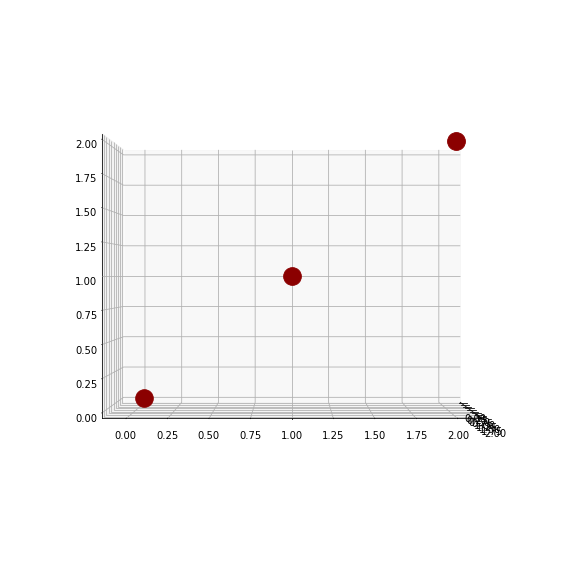

In [11]:
canvas = JupyterMatplotlibCanvas(size=400, delay=0.001, azimuth=0,elevation=0)
solar_system = SolarSystem(canvas)
body = SolarSystemBody(solar_system,"mars", mass=100, position=(0,0,0), velocity=(1, 1, 1),colour='darkred')
body.draw()  # (0,0,0)
body.move()
body.draw()  # (1,1,1)
body.move()
body.draw()  # (2,2,2)

The `clear()` and `update()` methods in `SolarSystem` clear the canvas then go through each body in the solar system updating its position.  We can use these methods to advance our object per the following code which should show the object moving from mid to top right:

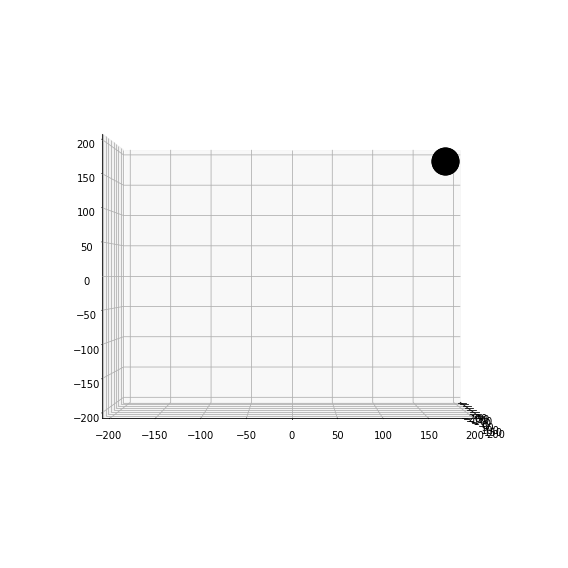

In [12]:
canvas = JupyterMatplotlibCanvas(size=400, delay=0.001, azimuth=0,elevation=0)
solar_system = SolarSystem(canvas)
body = SolarSystemBody(solar_system, "meteor", mass=10, position=(-100,-100,-100), velocity=(3, 3, 3))
for i in range(90):
    solar_system.clear()
    solar_system.update()

### 3.3 Adding the effects of gravity

The force due to gravity between two objects is defined as:

$$
F = \frac {G m_1 m_2} {r ^ 2}
$$

Since we’re using arbitrary units, we can ignore the gravitational constant `G`.  Once we know the force between two objects, we can work out the acceleration that each object is subject to using:

$$
a = \frac {F} {m}
$$

Once we know the acceleration, you can change the object’s velocity.  We can now use this knowledge to add a new method to `SolarSystemBody` called `accelerate_due_to_gravity`.  The neat decorator trick for doing this is described [in this Medium post](https://mgarod.medium.com/dynamically-add-a-method-to-a-class-in-python-c49204b85bd6).

In [13]:
from functools import wraps

def add_method(cls):
    def decorator(func):
        @wraps(func) 
        def wrapper(*args, **kwargs): 
            return func(*args, **kwargs)
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator

# this assigns the method to the class definition
@add_method(SolarSystemBody)
def accelerate_due_to_gravity(self, other):
    distance = Vector(*other.position) - Vector(*self.position)
    distance_mag = distance.magnitude()
    force_mag = self.mass * other.mass / (distance_mag ** 2)
    force = distance.normalize() * force_mag
    reverse = 1
    for body in self, other:
        acceleration = force / body.mass
        body.velocity += acceleration * reverse
        reverse = -1

In this method, `self` and other represent the two bodies interacting with each other.  Find the magnitude of the difference between the two body vectors.  Normalise to get unit vector then multiply by `force_mag`.  Calculate the force on each body and then work out the respective acceleration which will depend on relative mass. The `reverse` parameter ensures the opposite acceleration is applied to the second body since the two bodies are being pulled towards each other.

Let's check the `accelerate_due_to_gravity` method is actually present in the `SolarSystemBody` class along with `move` and `draw`:

In [14]:
def getNonDunderMethods(cls):
    return [a for a in dir(cls) if callable(getattr(cls, a)) and a[:2] != '__']

getNonDunderMethods(SolarSystemBody)

['accelerate_due_to_gravity', 'draw', 'move']

Now we have a way to work out the interaction between any two bodies, we can work out the interaction between all the bodies present in the solar system:

In [15]:
# this assigns the method to the class definition
@add_method(SolarSystem)
def calculate_all_body_interactions(self):
    bodies_copy = self.bodies.copy()
    for idx, first in enumerate(bodies_copy):
        for second in bodies_copy[idx + 1:]:
            first.accelerate_due_to_gravity(second)

Note that in this method the slice `idx + 1:` in the second `for` loop ensures we only work out the interactions between a body and those bodies that follow it in the list.

Again let's check we landed the method in the `SolarSystem` class:

In [16]:
getNonDunderMethods(SolarSystem)

['add_body', 'calculate_all_body_interactions', 'clear', 'update']

<div id='solar-system-planets'/>

## 4. `Sun` and `Planet` classes
[**back to Contents**](#solar-system-contents)

The `Sun` class uses a default mass of 10,000 units and sets the colour to yellow. We set it's `colour` to `yellow` for `matplotlib`.  The `Planet` class takes its colour from its constructor.

In [17]:
class Sun(SolarSystemBody):
    def __init__(
        self,
        solar_system,
        mass=10_000,
        position=(0, 0, 0),
        velocity=(0, 0, 0),
    ):
        colour = "yellow"
        name = "sun"
        super(Sun, self).__init__(solar_system, name, mass, position, velocity, colour)

class Planet(SolarSystemBody):
    def __init__(
        self,
        solar_system,
        name,
        mass=10,
        position=(0, 0, 0),
        velocity=(0, 0, 0),
        colour="red",
    ):
        super(Planet, self).__init__(solar_system, name, mass, position, velocity, colour)

Bringing it all together is the following solar system animation which can stopped by clicking the "interrupt kernel" button in the Jupyter toolbar per [this recipe](https://stackoverflow.com/questions/37280920/graceful-interrupt-of-while-loop-in-ipython-notebook)

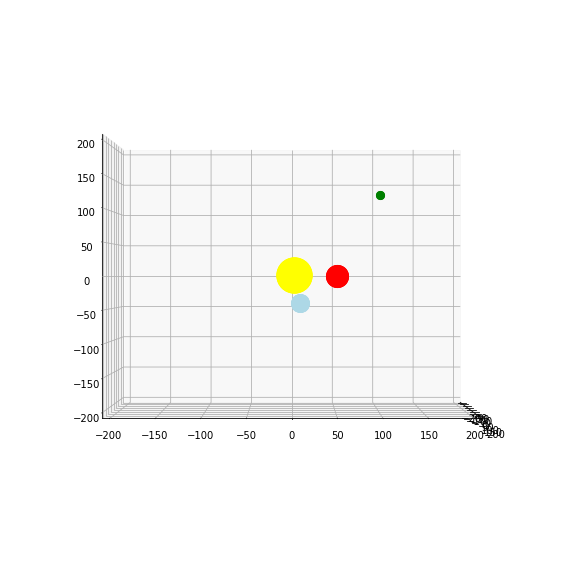

In [18]:
canvas = JupyterMatplotlibCanvas(size=400, delay=0.001, azimuth=0,elevation=0)
solar_system = SolarSystem(canvas)
sun = Sun(solar_system)
planets = (
    Planet(# earth like
        solar_system,
        name="earth",
        mass=10,
        position=(80, 50, 0),
        velocity=(0, 5, 5),
        colour="lightblue"
    ),
    Planet(# jupiter like
        solar_system,
        name="jupiter",
        mass=80,
        position=(180, 50, 0),
        velocity=(0, 5, 5),
        colour="green"
    ),
    Planet(# mars like
        solar_system,
        name="mars",
        mass=8,
        position=(120, 50, 0),
        velocity=(0, 5, 5),
        colour="red"
    )
)

try:
    while True:    
        solar_system.calculate_all_body_interactions()
        solar_system.clear()
        solar_system.update()
except KeyboardInterrupt:
    pass